<a href="https://colab.research.google.com/github/Comets-nana/24-25-Q1-Git-Session/blob/main/%5BPaliGemma_2%5DKeras_Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 케라스 PaliGemma 2 데모

케라스 허브를 사용한 [PaliGemma 2](https://ai.google.dev/gemma/docs/paligemma) 데모

We'll explore image captioning and object detection using 3B 가중치 모델을 사용해 이미지 캡셔닝과 객체 탐지를 수행해 보겠습니다.
[DOCCI](https://google.github.io/docci/) 데이터셋과 448*448 크기의 이미지로 미세 튜닝된 버전입니다.

## 설정

### 코랩 런타임 선택

T4 GPU를 선택합니다.


### 팔리젬마 설정

팔리젬마 접근 권한을 요청하고 캐글 토큰을 준비합니다.

### 환경 변수 설정

`KAGGLE_USERNAME`와 `KAGGLE_KEY` 환경 변수를 설정합니다.

In [ ]:
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

### Install dependencies

Install Keras and KerasNLP.

In [ ]:
# 케라스 백엔드 설정
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_hub
import keras

# 반정밀도 부동소수점 사용
keras.config.set_floatx("bfloat16")

## 이미지 로드

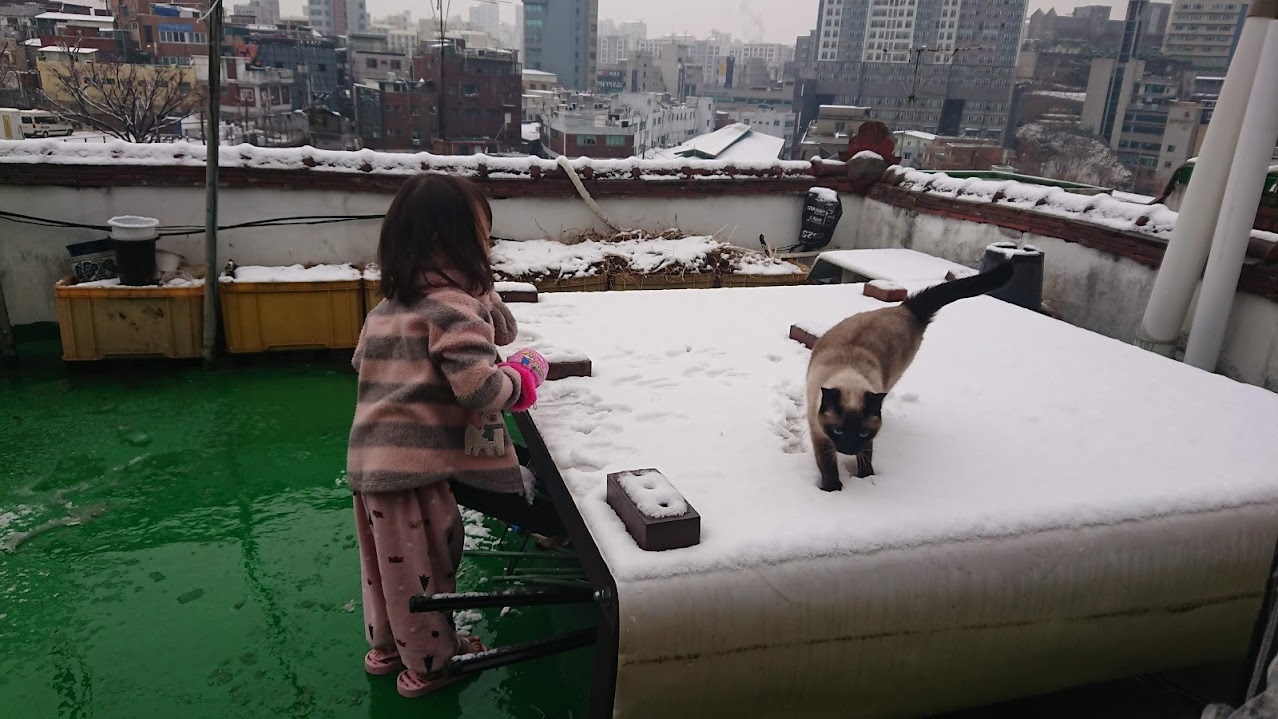

In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from keras.utils import img_to_array
import requests

img_url = "https://github.com/bebechien/gemma/blob/main/PaliGemma_Demo.JPG?raw=true"
input_image = Image.open(requests.get(img_url, stream=True).raw)

from IPython.display import display
display(input_image)

###############################
# some helper functions below #
###############################
import cv2
import re

def draw_bounding_box(image, coordinates, label, label_colors, width, height):
    y1, x1, y2, x2 = coordinates
    y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))

    text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)
    text_width, text_height = text_size

    text_x = x1 + 2
    text_y = y1 - 5

    font_scale = 1
    label_rect_width = text_width + 8
    label_rect_height = int(text_height * font_scale)

    color = label_colors.get(label, None)
    if color is None:
        color = np.random.randint(0, 256, (3,)).tolist()
        label_colors[label] = color

    cv2.rectangle(image, (x1, y1 - label_rect_height), (x1 + label_rect_width, y1), color, -1)

    thickness = 2
    cv2.putText(image, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    return image

def draw_results(paligemma_response):
  detections = paligemma_response.split(" ; ")
  parsed_coordinates = []
  labels = []
  label_colors = {}
  output_image = input_image
  output_img = np.array(input_image)

  if len(detections) > 1:
    for item in detections:
      detection = item.replace("<loc", "").split()

      if len(detection) >= 2:
        coordinates_str = detection[0]
        coordinates = coordinates_str.split(">")
        coordinates = coordinates[:4]

        if coordinates[-1] == '':
          coordinates = coordinates[:-1]

        coordinates = [int(coord)/1024 for coord in coordinates]
        parsed_coordinates.append(coordinates)

        for label in detection[1:]:
          if "<seg" in label:
            continue
          else:
            labels.append(label)

      else:
        # No label detected, skip the iteration.
        continue

      width = input_image.size[0]
      height = input_image.size[1]

      # Draw bounding boxes on the frame.
      image = cv2.cvtColor(np.array(input_image), cv2.COLOR_RGB2BGR)
      for coordinates, label in zip(parsed_coordinates, labels):
        output_img = draw_bounding_box(output_img, coordinates, label, label_colors, width, height)

      output_image = Image.fromarray(output_img)

  elif len(detections) == 1:
    for item in detections:
      detection = item.split("<loc")

      if len(detection) >= 5:
        coordinates = []
        for value in detection[1:5]:
          coordinates.append(value.split(">")[0])

        if coordinates[-1] == '':
          coordinates = coordinates[:-1]

        coordinates = [int(coord)/1024 for coord in coordinates]
        parsed_coordinates.append(coordinates)
        labels.append("object")

      else:
        # No label detected, skip the iteration.
        continue

      width = input_image.size[0]
      height = input_image.size[1]

      # Draw bounding boxes on the frame.
      image = cv2.cvtColor(np.array(input_image), cv2.COLOR_RGB2BGR)
      for coordinates, label in zip(parsed_coordinates, labels):
        output_img = draw_bounding_box(output_img, coordinates, label, label_colors, width, height)

      output_image = Image.fromarray(output_img)

  return output_image

## 모델 로드

In [ ]:
model_name = "kaggle://keras/paligemma2/keras/pali_gemma_2_ft_docci_3b_448"

target_size = (448, 448)

pali_gemma_lm = keras_hub.models.PaliGemmaCausalLM.from_preset(model_name)
pali_gemma_lm.summary()

Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (448, 448) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 448, 448, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2304)        │   3,032,979,696 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     592,478,208 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,032,979,696 (5.65 GB)

 Trainable params: 3,032,979,696 (5.65 GB)

 Non-trainable params: 0 (0.00 B)

## 추론

caption en
A medium view of a girl and a cat on a rooftop. The girl is facing the right side and is looking at the cat that is standing on a large white platform that is covered in snow. The cat is looking at the girl and is brown and white. The platform is sitting on a green floor that is wet. Behind the cat and girl, there is a white wall that has a red brick border. On the left side of the platform, there is a yellow box that is filled with snow. Behind the platform, there are many buildings that are covered in snow.


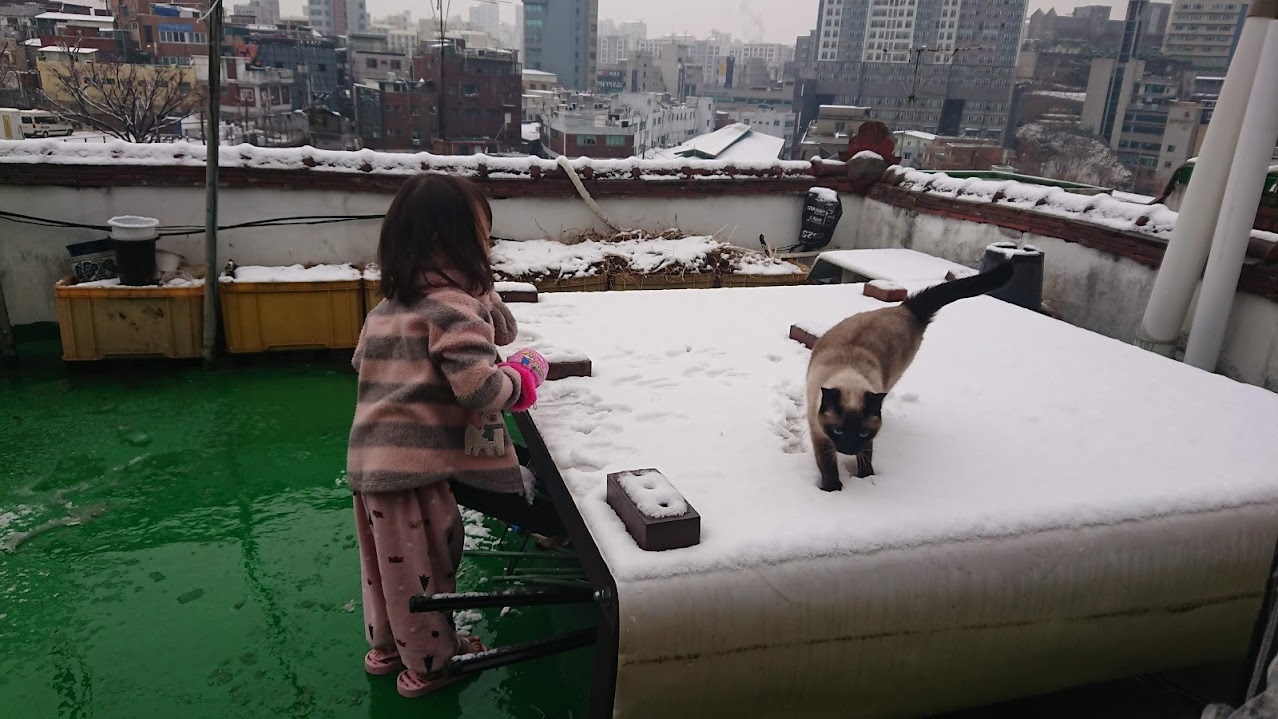

In [ ]:
########
input_text = "caption en\n"
result = pali_gemma_lm.generate(
    inputs={
        "images": img_to_array(input_image.resize(target_size)),
        "prompts": input_text,
    }
)
print(result)

draw_results(result[len(input_text):])

detect cat ; person
<loc0240><loc0277><loc0985><loc0439> person ; <loc0359><loc0644><loc0699><loc0825> cat


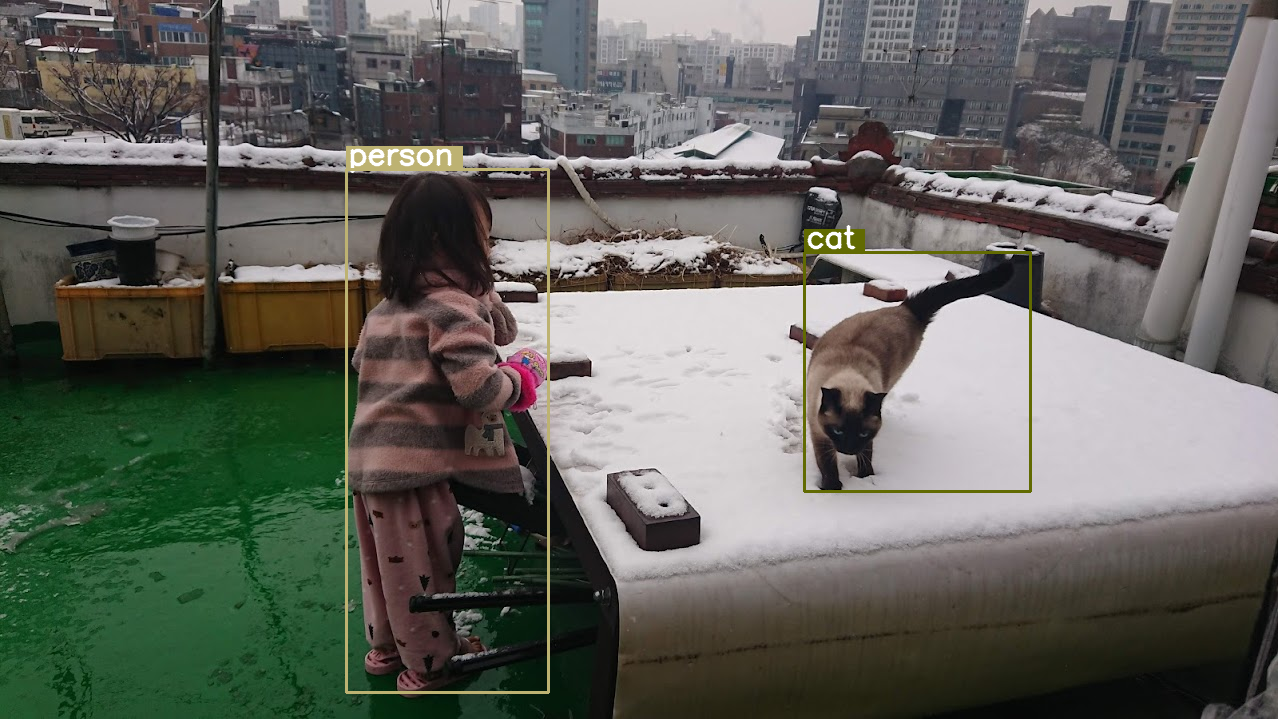

In [ ]:
########
input_text = "detect cat ; person\n"
result = pali_gemma_lm.generate(
    inputs={
        "images": img_to_array(input_image.resize(target_size)),
        "prompts": input_text,
    }
)
print(result)

draw_results(result[len(input_text):])